In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm

In [18]:
class TUMDataset(Dataset):
    def __init__(self, rgb_file, depth_file, gt_file, transform=None, depth_transform=None, base_dir=""):
        rgb_file = os.path.join(base_dir,rgb_file)
        depth_file = os.path.join(base_dir,depth_file)
        gt_file = os.path.join(base_dir,gt_file)
        self.rgb_data = self._read_file(rgb_file)
        self.depth_data = self._read_file(depth_file)
        self.gt_data = self._read_file(gt_file)

        n = min(len(self.rgb_data), len(self.depth_data), len(self.gt_data))
        self.rgb_data = self.rgb_data[:n]
        self.depth_data = self.depth_data[:n]
        self.gt_data = self.gt_data[:n]

        self.transform = transform
        self.depth_transform = depth_transform
        self.base_dir = base_dir

    def _read_file(self, filename):
        with open(filename, 'r') as f:
            lines = [line.strip() for line in f if line.strip() and not line.startswith("#")]
        data = []
        for line in lines:
            parts = line.replace(",", " ").replace("\t", " ").split()
            timestamp = float(parts[0])
            data.append((timestamp, parts[1:]))
        return data

    def __len__(self):
        return len(self.rgb_data)

    def __getitem__(self, idx):
        rgb_path = os.path.join(self.base_dir, self.rgb_data[idx][1][0])
        depth_path = os.path.join(self.base_dir, self.depth_data[idx][1][0])
        pose_vals = list(map(float, self.gt_data[idx][1]))

        rgb = Image.open(rgb_path).convert("RGB")
        depth = Image.open(depth_path).convert("I")  # 'I' mode for 32-bit integer pixels

        if self.transform:
            rgb = self.transform(rgb)
        if self.depth_transform:
            depth = self.depth_transform(depth)
            if depth.ndim == 2:  # If shape is [H, W], add channel dimension
                depth = depth.unsqueeze(0)

        pose = torch.tensor(pose_vals, dtype=torch.float32)

        return {
            "rgb": rgb,
            "depth": depth,
            "pose": pose
        }

In [19]:
# ...existing code...
class PoseNet(nn.Module):
    def __init__(self, pretrained=True):
        super(PoseNet, self).__init__()
        resnet = models.resnet18(pretrained=pretrained)
        # Modify first conv layer to accept 4 channels
        self.encoder = nn.Sequential(*list(resnet.children())[:-1])
        self.encoder[0] = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.fc = nn.Linear(512, 7)

    def forward(self, rgb, depth):
        # Concatenate along channel dimension
        x = torch.cat([rgb, depth], dim=1)
        x = self.encoder(x).view(x.size(0), -1)
        out = self.fc(x)
        trans = out[:, :3]
        rot = F.normalize(out[:, 3:], dim=-1)
        return torch.cat([trans, rot], dim=1)
# ...existing code...

In [20]:
# Resize to ResNet input
rgb_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

depth_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x / 5000.0)  # Normalize depth to [0,1] if max depth is 5000mm
])

# Adjust this path to your dataset
dataset = TUMDataset(
    rgb_file="rgb.txt",
    depth_file="depth.txt",
    gt_file="groundtruth.txt",
    transform=rgb_transform,
    depth_transform=depth_transform,
    base_dir="rgbd_dataset_freiburg3_long_office_household"  # assumes images/rgb and images/depth are in paths in txt files
)

dataloader = DataLoader(dataset, batch_size=8, shuffle=True)


In [21]:
from torch.utils.data import random_split

# Set the split ratio (e.g., 80% train, 20% test)
train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

# Create the splits
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [22]:
def pose_loss(pred, target, beta=1.0):
    t_pred = pred[:, :3]
    q_pred = F.normalize(pred[:, 3:], dim=-1)
    t_gt = target[:, :3]
    q_gt = F.normalize(target[:, 3:], dim=-1)
    loss_t = F.mse_loss(t_pred, t_gt)
    loss_q = F.mse_loss(q_pred, q_gt)
    return loss_t + beta * loss_q

model = PoseNet().to("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)



In [23]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# num_epochs = 25

# for epoch in range(num_epochs):
#     model.train()
#     total_loss = 0
#     for batch in tqdm(train_loader):
#         rgb = batch["rgb"].to(device)
#         pose = batch["pose"].to(device)
#         depth = batch["depth"].to(device)

#         pred = model(rgb,depth)
#         loss = pose_loss(pred, pose)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()

#     print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(dataloader):.4f}")


In [24]:
model.eval()
with torch.no_grad():
    sample = next(iter(test_loader))
    pred = model(sample['rgb'].to(device),sample['depth'].to(device))
    print("Predicted Pose:", pred[0].cpu().numpy())
    print("Ground Truth Pose:", sample['pose'][0].numpy())


Predicted Pose: [ 0.19733503  0.7314857  -0.42292476 -0.12464122 -0.34167522 -0.22780631
 -0.9032313 ]
Ground Truth Pose: [ 1.5906 -1.2059  1.5538  0.7337  0.4288 -0.2746 -0.4499]


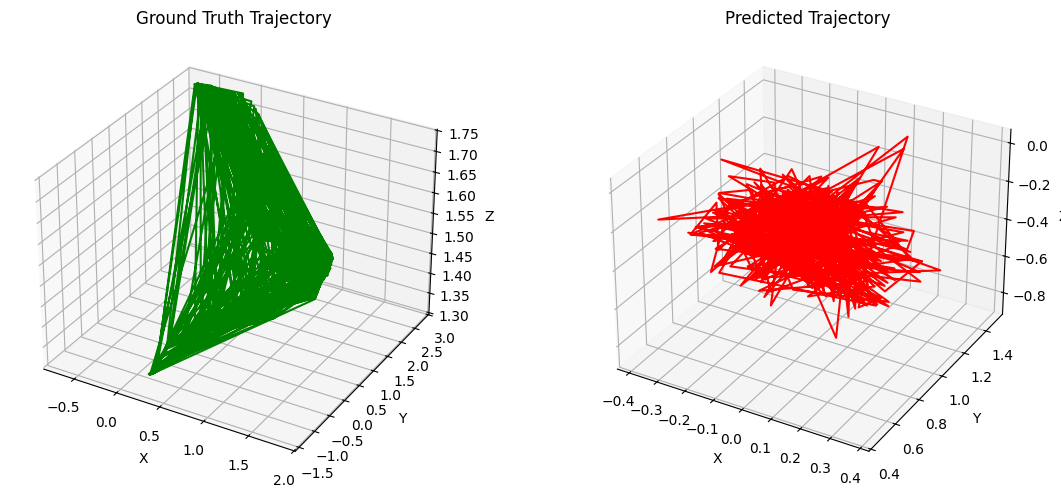

In [25]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
device = 'cuda'
# Evaluate model
preds, gts = [], []
model.eval()
with torch.no_grad():
    for batch in test_loader:
        rgb = batch['rgb'].to(device)
        depth = batch['depth'].to(device)
        gt = batch['pose'].cpu().numpy()
        pred = model(rgb,depth).cpu().numpy()

        preds.append(pred[:, :3])
        gts.append(gt[:, :3])

preds = np.concatenate(preds)
gts = np.concatenate(gts)

# Plot
fig = plt.figure(figsize=(12, 5))

# Ground Truth Plot
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(gts[:, 0], gts[:, 1], gts[:, 2], c='green')
ax1.set_title("Ground Truth Trajectory")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.set_zlabel("Z")

# Predicted Plot
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(preds[:, 0], preds[:, 1], preds[:, 2], c='red')
ax2.set_title("Predicted Trajectory")
ax2.set_xlabel("X")
ax2.set_ylabel("Y")
ax2.set_zlabel("Z")

plt.tight_layout()
plt.show()


In [26]:
# # Save the model parameters (recommended)
# torch.save(model.state_dict(), "posenet_rgbd.pth")


In [27]:
import torch
checkpoint = torch.load('posenet_rgbd.pth')


In [28]:
model = PoseNet()
model.load_state_dict(checkpoint)

<All keys matched successfully>